# Robust paramater uncertainties
`Tweezepy` contains two different methods for calculating uncertainties. The first method relies on the Hessian of the maximum likelihood estimate. It is fast and sufficient for most circumstances; however, it relies on a Gaussian approximation that may not be valid in some cases (i.e., small sample sizes and parasitic noise). In these cases, a more robust option is to numerically sample the probability distribution of the parameters using a Markov Chain Monte Carlo (MCMC) sampler and estimate errors.

Here is an example showing how to use the MCMC method in `Tweezepy`. First, we'll load in some example data.

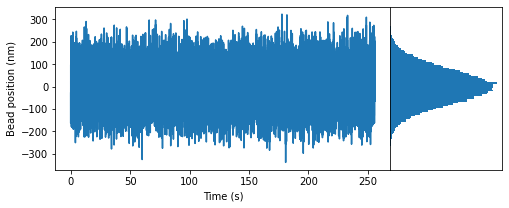

In [2]:
import numpy as np # Loads the numpy package
import matplotlib.pyplot as plt # Loads the matplotlib package for plotting
from tweezepy import load_trajectory # Loads in the exampled trajectory in tweezepy
fsample = 400 # sampling frequency in Hz
trace = load_trajectory() # load in trajectory in nm
N = len(trace) # number of points in trajectory
time = np.arange(N)/fsample # time in s
fig,ax = plt.subplots(figsize=(8,3), # Figure size
                      ncols=2, # number of columns in figure
                      gridspec_kw={'width_ratios':[3,1], # width ratio of columns
                                   'wspace':0}) # space between columns
ax[0].plot(time, trace) # Plot bead positions as a function of time
ax[1].hist(trace, bins=100, orientation = 'horizontal') # Plot histogram of bead positions
ax[0].set_xlabel('Time (s)') # Label x axis
ax[0].set_ylabel('Bead position (nm)') # Label yaxis
ax[1].set_xticks([]) # Remove xticks on histogram axis
ax[1].set_yticks([]); # Remove yticks on historgram axis

### Calculate power spectral density (PSD) and fit it 
Now, we'll calculate the experimental PSD and fit it using maximum likelihood estimation.

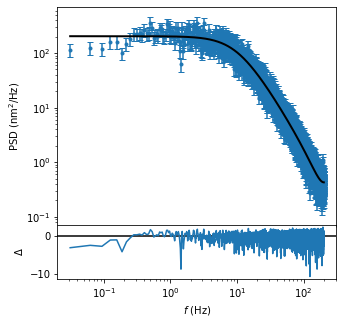

In [4]:
from tweezepy import PSD
psd = PSD(trace,fsample,bins = 15)
psd.mlefit()
psd.plot();

## Markov Chain Monte Carlo (MCMC) sampling
This tutorial won't go into how or why Monte Carlo sampling works. For more information on MCMC, I suggest checking out [Numerical Recipes](http://numerical.recipes/book/book.html). Rather, this tutorial shows how to use the MCMC 

Once a MLE fit is obtained, we can sample the parameter space using the `emcee` Python package. By default, 32 walkers are initialized in a tiny Gaussian ball around the MLE result and then run though 2,000 steps of MCMC.

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
100%|██████████| 2000/2000 [01:24<00:00, 23.70it/s]


(<Figure size 720x432 with 2 Axes>,
 [<AxesSubplot:ylabel='$\\gamma$ (pNs/nm)'>,
  <AxesSubplot:xlabel='step number', ylabel='$\\kappa$ (pN/nm)'>])

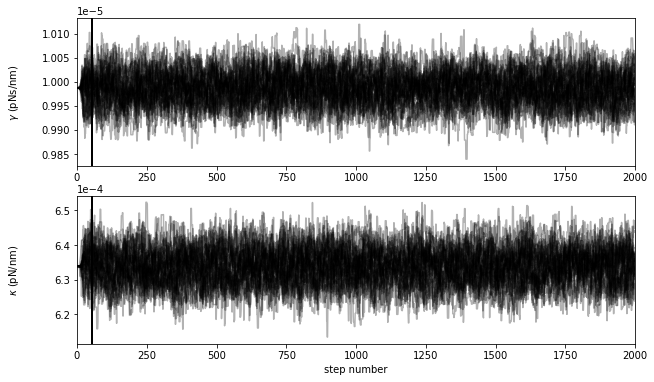

In [5]:
psd.mcmc()
psd.sample_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"])

This plot shows the positions of each walker as a function of the number of steps in the chain. As mentioned above, the walkers start in small Gaussian ball around the MLE results but quickly wander and explore the full paramater distribution. 

It takes the sampler some time to 'forget' the initial state, so we'll throw out twice the autocorrelation time (black vertical line). Then, we'll thin the samples by half the autocorrelation time to ensure the values at each step are uncorrelated. 

### Results
Now that we have a list of sampler positions, we can visualize the parameter distributions using a corner plot (i.e., the 1 and 2D histograms). This uses the `corner` package, which is separate from the emcee package and will need to be installed separately. Once it's installed, we can automatically generate a corner plot.

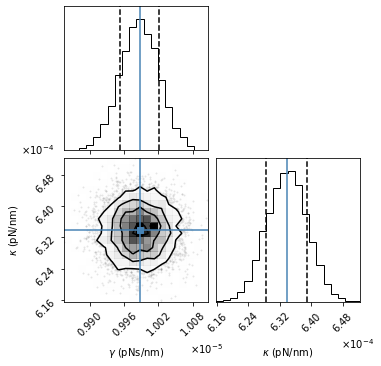

In [6]:
psd.corner_plot(labels=[r"$\gamma$ (pNs/nm)",r"$\kappa$ (pN/nm)"]);

The above plot shows all the one and two dimensional projections of the parameter distributions. The MLE best-fit parameter estimates are indicated by the blue lines. The dotted black lines in the 1D histograms are the 16th and 84th percentiles. The black contour lines in the 2D histogram are the 1, 2, and 3 standard deviations.

After running the mcmc sampler, the one standard deviation errors are automatically added to the results dictionary.

In [7]:
# The mcmc results are automatically added to the results dictionary
psd.results

{'chi2': 9541.523752905014,
 'redchi2': 1.4915622561990016,
 'g': 9.987274585927754e-06,
 'g_error': 4.939065221213263e-08,
 'k': 0.0006338066057220219,
 'k_error': 7.270886693644723e-06,
 'support': 1.0,
 'p-value': 0.0,
 'AIC': 13644.000903245327,
 'AICc': 13644.002779417935,
 'g_mcmc': 9.987021282772244e-06,
 'g_mcmc_error': 3.435220336428895e-08,
 'k_mcmc': 0.0006338804318451684,
 'k_mcmc_error': 5.236844753965118e-06}

The results can be accessed directly through the results dictionary.

In [11]:
from IPython.display import display, Math
txt = r"$\gamma = %.1e\pm%.1e\textrm{ pNs/nm}$"%(psd.results['g_mcmc'],psd.results['g_mcmc_error'])
display(Math(txt))
txt = r"$\kappa = %.1e\pm%.1e\textrm{ pN/nm}$"%(psd.results['k_mcmc'],psd.results['k_mcmc_error'])
display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>